In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import seaborn as sns
from scipy import interpolate, optimize
import os
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# Model diagram

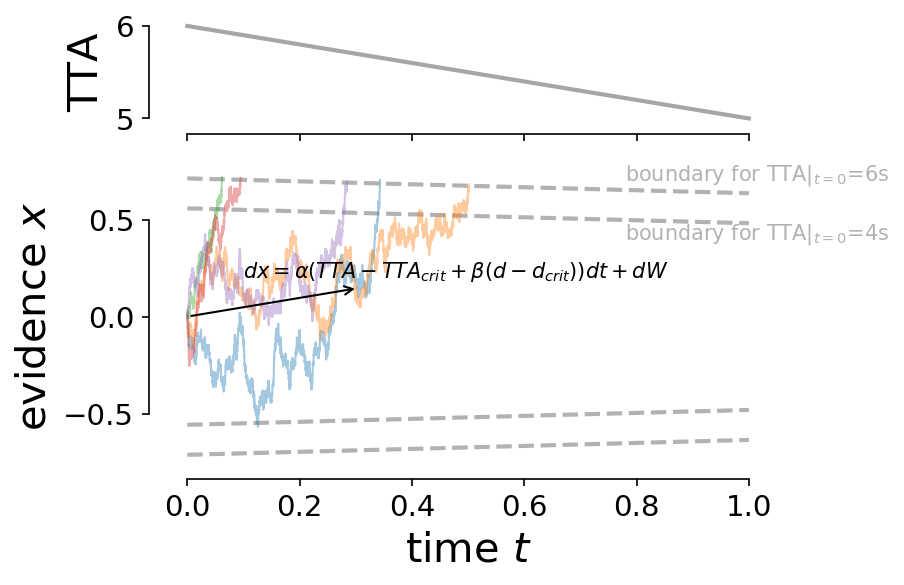

In [2]:
'''Parameter values:  
drift=DriftTtaDistance(
    alpha=Fitted(0.981751568572023, minval=0.1, maxval=3), 
    tta_crit=Fitted(4.540489436924537, minval=3, maxval=6),  
    beta=Fitted(0.044790083741267264, minval=0, maxval=1), 
    d_crit=Fitted(126.47533311922697, minval=90, maxval=150)), 
noise=NoiseConstant(noise=1), 
bound=BoundCollapsingTta(
    b_0=Fitted(1.194837718254345, minval=0.5, maxval=5),
    k=Fitted(0.2613552424813064, minval=0.1, maxval=2), 
    tta_crit=Fitted(4.540489436924537, minval=3, maxval=6)), 
overlay=OverlayNonDecisionUniform(
    nondectime=Fitted(0.3282945154873583, minval=0, maxval=0.5), 
    halfwidth=Fitted(0.22718767060769995, minval=0, maxval=0.3))
'''

def get_trace():
    noise = np.random.randn(len(t))
    drift = alpha*(tta-tta_crit+beta*(d-d_crit))
    dx = drift * dt + noise * np.sqrt(dt)
    x = np.append([0], np.cumsum(dx)[:-1])
    nd_time_idx = int(np.random.uniform(nd_time_mean-nd_halfwidth, nd_time_mean+nd_halfwidth) // dt)
    nd_time = t[nd_time_idx]
    
    return x

def add_inset(ax):
    ax_ins = inset_axes(ax, width=1.3, height=0.9, loc='center right')
    tau_ins = np.linspace(0, 10)
    f = 1/(1+np.exp(-k*(tau_ins-tta_crit)))
    f_approx = 0.5 + 0.05*(tau_ins-tta_crit)

    ax_ins.plot(tau_ins, f)
    ax_ins.plot(tau_ins, f_approx)
    ax_ins.axvline(tta_crit, color='grey', ls='--', lw=1)
    ax_ins.set_xlabel(r'$\tau$', fontsize=8)
    ax_ins.set_ylabel('boundary', fontsize=8)
    ax_ins.set_title(r'$f(\tau) = b_0/(1+e^{-k(\tau-\tau_{crit})})$', fontsize=8)
    ax_ins.text(x=tta_crit, y=0.3, s=r'$\tau_{crit}$', fontsize=8);
    ax_ins.tick_params(axis='both', which='major', labelsize=8)

    sns.despine(offset=5, trim=True)

tta_condition = 6
d_condition = 120

alpha = 0.98
tta_crit = 4.54
beta = 0.04479
d_crit = 126.6
b_0 = 1.2
k = 0.26
nd_time_mean = 0.328
nd_halfwidth = 0.227

v_condition = d_condition / tta_condition
dt = 0.0001
t = np.arange(0, 1.0, dt)
d = d_condition - v_condition*t

fig, (ax_tau, ax) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [1, 3]}, dpi=150, sharex=True)

ax.annotate(r'$dx = \alpha(TTA-TTA_{crit} + \beta(d-d_{crit})) dt + dW$', xy=(0,0), xytext=(0.1, 0.2),
             arrowprops=dict(arrowstyle='<-', connectionstyle='arc3'))

for tta_condition in [4, 6]:
    tta = tta_condition - t
    boundary = b_0/(1+np.exp(-k*(tta-tta_crit)))
    ax.plot(t, boundary, ls='--', color='gray', alpha=0.6)
    ax.plot(t, -boundary, ls='--', color='gray', alpha=0.6)
    ax.text(0.78, 0.4+0.15*(tta_condition-4), r'boundary for TTA$|_{t=0}$=%is' % (tta_condition), color='grey', alpha=0.6)
    
trials = [get_trace() for i in range(5)]

for x in trials:
    response_time_idx = np.where(abs(x)>boundary)[0][0]
    response_time = t[response_time_idx]
    ax.plot(t[t<=response_time], x[t<=response_time], lw=1.0, alpha=0.4)
    
    ax.set_xlabel(r'time $t$')
    ax.set_ylabel(r'evidence $x$')
    
#     ax.text(0.8, 0.7, r'boundary $b=f(\tau)$', color='grey', alpha=0.6)
#     ax.text(0.8, -0.75, r'boundary $b=-f(\tau)$', color='grey', alpha=0.6)

ax_tau.plot(t, tta, color='grey', alpha=0.7)
# ax_tau.axhline(tta_crit, ls='--')
ax_tau.set_ylabel('TTA')

sns.despine(offset=5, trim=True)
plt.tight_layout()
plt.savefig('figures/model_diagram.png', bbox_inches='tight')

# Trial timeline

In [4]:
data = pd.read_csv('processed_data.csv', index_col=['subj_id', 'session', 'route', 'intersection_no'])
traj_id = (129, 1, 2, 5)
traj = data.loc[traj_id]

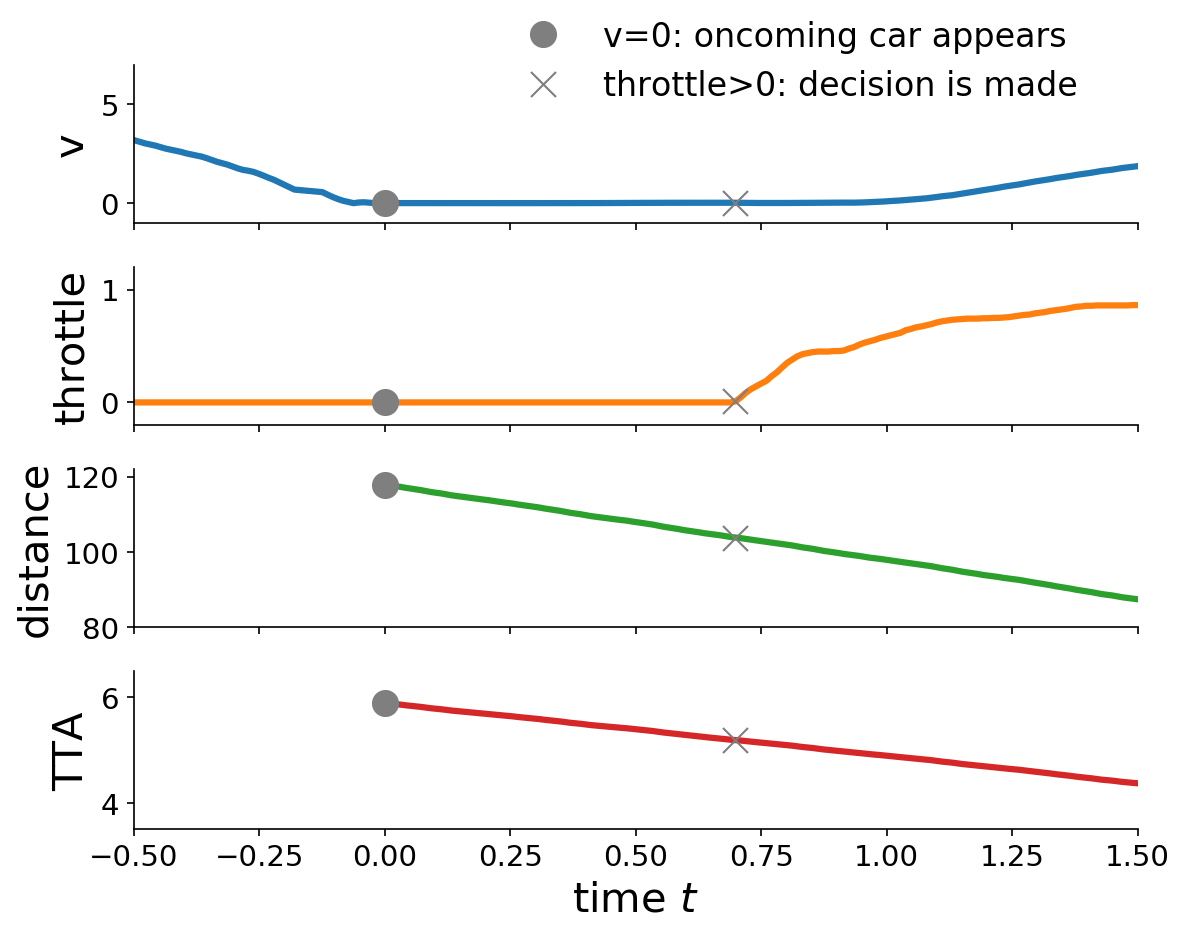

In [9]:
def plot_traj(traj):    
    idx_bot_spawn = int(traj.iloc[0].idx_bot_spawn)
    idx_response = int(traj.iloc[0].idx_response)
    idx_min_distance = int(traj.iloc[0].idx_min_distance)
    tta = int(traj.iloc[0].tta_condition)
    d = int(traj.iloc[0].d_condition)
    
    traj.loc[:, 't'] -= traj.t.values[idx_bot_spawn]
    
    fig, axes = plt.subplots(4, 1, figsize=(8,6), dpi=150, sharex=True)
    ms = 12
    lw=3
    axes[0].plot(traj.t, traj.ego_v, color='C0', lw=lw)
    axes[0].plot(traj.t[idx_bot_spawn], traj.ego_v[idx_bot_spawn], color='C7', ls='', marker='o', ms=ms)
    axes[0].plot(traj.t[idx_response], traj.ego_v[idx_response], color='C7', ls='', marker='x', ms=ms)
    axes[0].set_ylabel('v')
    axes[0].set_ylim((-1, 7))

    axes[1].plot(traj.t, traj.throttle, color='C1', lw=lw)
    axes[1].plot(traj.t[idx_bot_spawn], traj.throttle[idx_bot_spawn], color='C7', ls='', marker='o', ms=ms)
    axes[1].plot(traj.t[idx_response], traj.throttle[idx_response], color='C7', ls='', marker='x', ms=ms)
    axes[1].set_ylabel('throttle')
    axes[1].set_ylim((-0.2, 1.2))

    axes[2].plot(traj.t[idx_bot_spawn:], traj.d_ego_bot[idx_bot_spawn:], color='C2', lw=lw)
    axes[2].plot(traj.t[idx_bot_spawn], traj.d_ego_bot[idx_bot_spawn], color='C7', ls='', marker='o', ms=ms)
    axes[2].plot(traj.t[idx_response], traj.d_ego_bot[idx_response], color='C7', ls='', marker='x', ms=ms)
    axes[2].set_ylabel('distance')
    axes[2].set_ylim((80, 122))

    axes[3].plot(traj.t[idx_bot_spawn:], traj.tta[idx_bot_spawn:], color='C3', lw=lw)
    axes[3].plot(traj.t[idx_bot_spawn], traj.tta[idx_bot_spawn], color='C7', ls='', marker='o', 
                 label='v=0: oncoming car appears', ms=ms)
    axes[3].plot(traj.t[idx_response], traj.tta[idx_response], color='C7', ls='', marker='x', 
                 label='throttle>0: decision is made', ms=ms)
    axes[3].set_ylabel('TTA')
    axes[3].set_ylim((3.5, 6.5))

    axes[3].set_xlim((-0.5, 1.5))
    
    axes[3].set_xlabel('time $t$')

    legend = fig.legend(loc='upper left', bbox_to_anchor=(0.4, 1.05), frameon=False)
    legend.get_title().set_fontsize('18')
    plt.tight_layout()
    
plot_traj(traj)
plt.savefig('figures/trial_timeline.png', bbox_inches='tight')

# Probability of turn

In [15]:
fit_results_path = 'model_fit_results/tta_and_d/5_tta-_and_d-dependent_drift_and_bounds_and_uniformly_distributed_nondecision_time'
model_measures = pd.read_csv(os.path.join(fit_results_path, 'measures.csv'))

In [12]:
exp_data = pd.read_csv('measures.csv')
subjects = exp_data.subj_id.unique()
d_conditions = np.sort(exp_data.d_condition.unique())

In [23]:
def plot_var_by_subject(data, model_measures, var, ylabel):
    fig, axes = plt.subplots(2, 4, figsize=(12,6), sharex=True, sharey=True)
    ax = axes[0][0]
    ax.set_title('all subjects', fontsize=16)
    sns.pointplot(ax=axes[0][0], data=data, 
                      x='tta_condition', y=var, hue='d_condition', join=False, dodge=0.05,
                      markers=['o', 's', '^'], hue_order=d_conditions, scale=0.8, errwidth=2)

    for d_condition, marker in zip(d_conditions, ['o', 's', '^']):
        ax.plot([0, 1, 2], model_measures.loc[model_measures.d_condition==d_condition, var], zorder=0.1)

    ax.legend().remove()
    ax.set_xlabel('')
    ax.set_ylabel('')

    for subj_id, ax in zip(subjects, axes.flatten()[1:]):
        ax.set_title(subj_id, fontsize=16)
        if not ((subj_id == 616) & (var=='RT')):
            sns.pointplot(ax=ax, data=data[data.subj_id==subj_id], 
                      x='tta_condition', y=var, hue='d_condition', join=False, dodge=0.05,
                      markers=['o', 's', '^'], scale=1, errwidth=2)
        else:
            sns.pointplot(ax=ax, data=data[data.subj_id==subj_id], 
                      x='tta_condition', y=var, hue='d_condition', join=False, dodge=0.05,
                      markers=['s', '^'], palette=['C1', 'C2'], scale=1, errwidth=2)

        subj_fit_results_path = os.path.join(fit_results_path, str(subj_id))
        subj_model_measures = pd.read_csv(os.path.join(subj_fit_results_path, 'measures.csv'))
        for d_condition, marker in zip(d_conditions, ['o', 's', '^']):
            ax.plot([0, 1, 2], subj_model_measures.loc[subj_model_measures.d_condition==d_condition, var], 
                    zorder=0.1)

        ax.legend().remove()
        ax.set_xlabel('')
        ax.set_ylabel('')
    plt.tight_layout()
    sns.despine(offset=5, trim=True)

    legend_elements = [Line2D([0], [0], color='C0', marker='o', lw=0, label='Data, d=90m'),
                       Line2D([0], [0], color='C1', marker='s', lw=0, label='Data, d=120m'),
                       Line2D([0], [0], color='C2', marker='^', lw=0, label='Data, d=150m'),
                       Line2D([0], [0], color='grey', label='Model fits')]

    fig.legend(handles=legend_elements, loc='center', bbox_to_anchor=(1.15, 0.55), fontsize=16, frameon=False)

    fig.text(0.4, -0.05, 'time-to-arrival (TTA), s', fontsize=18)
    fig.text(-0.03, 0.3, ylabel, fontsize=18, rotation=90)
    
    return axes

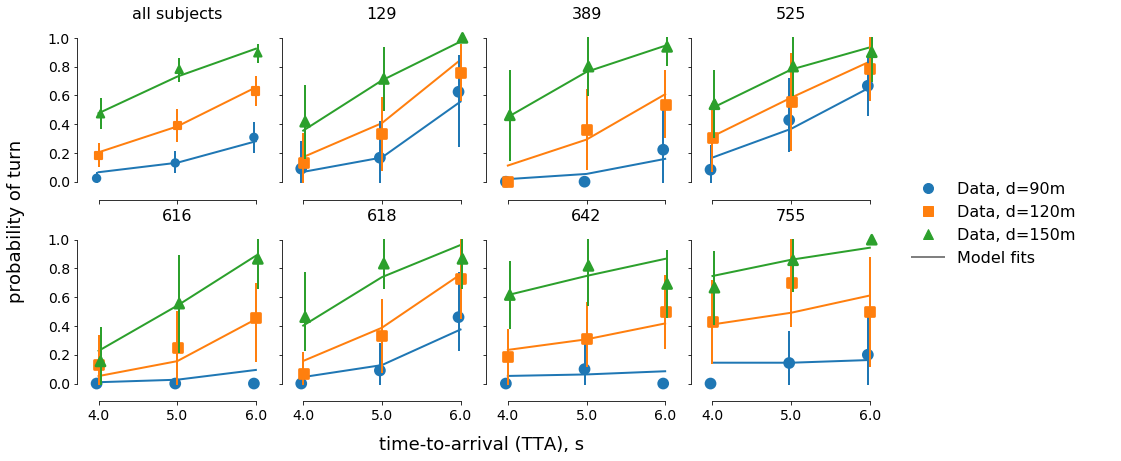

In [24]:
plot_var_by_subject(data=exp_data, model_measures=model_measures, var='is_turn_decision', ylabel='probability of turn')
plt.savefig('figures/p_turn.png', bbox_inches='tight')

# Response times for "turn" decisions

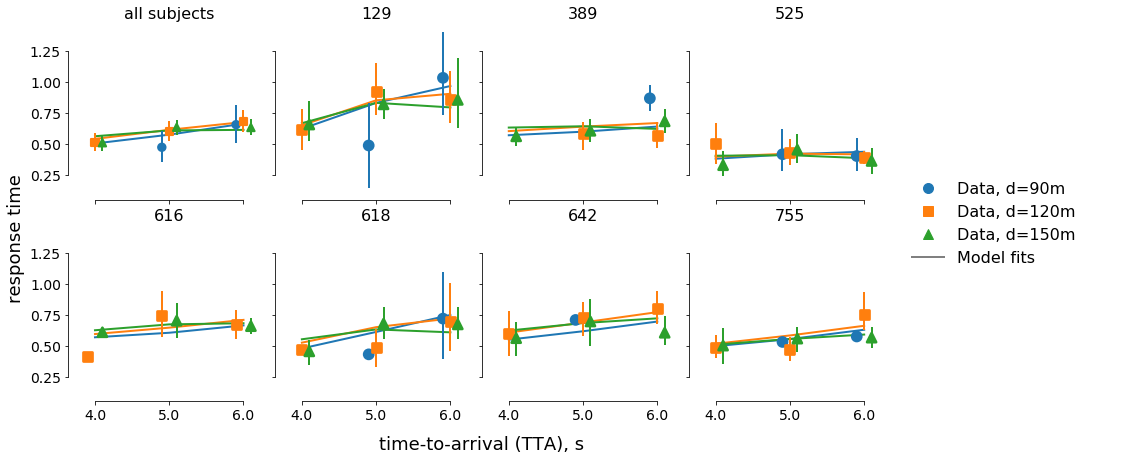

In [99]:
# only two data points are available for the (4, 90) condition, should ignore it altogether
exp_data.loc[(exp_data.d_condition==90) & (exp_data.tta_condition==4), 'RT'] = np.nan
axes = plot_var_by_subject(data=exp_data[exp_data.is_turn_decision], var='RT', ylabel='response time')
plt.savefig('figures/RT.png', bbox_inches='tight')

# RT distributions

In [48]:
def plot_rt_pdfs(exp_data, model_rts):
    fig, axes = plt.subplots(3, 3, figsize=(10,8), sharex=True, sharey=True)
    conditions = [(d, tta) 
                  for d in sorted(exp_data.d_condition.unique()) 
                  for tta in sorted(exp_data.tta_condition.unique())]
    for (ax, condition) in zip(axes.flatten(), conditions):
        model_hist = model_rts[(model_rts.d_condition==condition[0]) & (model_rts.tta_condition==condition[1])]
        exp_rts = exp_data[(exp_data.is_turn_decision) 
                            & (exp_data.d_condition==condition[0]) 
                            & (exp_data.tta_condition==condition[1])].RT
        if len(exp_rts) >= 10:
            ax.plot(model_hist.t, model_hist.rt_corr_pdf, label='Model', color='grey')
            sns.distplot(a=exp_rts, ax=ax, label='Experiment', color='C1', kde_kws={'clip': (0.0, exp_rts.max())})
        ax.set_xlabel('')
        ax.set_xlim((0, 2.5))
        ax.text(0.7, 0.8, 'N=%i' % len(exp_rts), fontsize=16, transform=ax.transAxes,  
                horizontalalignment='center', verticalalignment='center')
        
    for ax, d in zip(axes[0], sorted(exp_data.d_condition.unique())):
        ax.text(0.5, 0.99, 'd=%im' % d, fontsize=18, transform=ax.transAxes,
                horizontalalignment='center', verticalalignment='center')
        
    for ax, tta in zip(axes.T[2], sorted(exp_data.tta_condition.unique())):
        ax.text(0.99, 0.5, 'TTA=%is' % tta, fontsize=18, transform=ax.transAxes, rotation=-90, 
                horizontalalignment='center', verticalalignment='center')
#     plt.tight_layout()
    legend_elements = [Patch(facecolor='C1', alpha=0.5, label='Data'),
                       Line2D([0], [0], color='grey', lw=2, label='Model')]

    
    fig.legend(handles=legend_elements, loc='center', bbox_to_anchor=(.98, 0.5), fontsize=16, frameon=False)
    fig.text(0.5, 0.04, 'RT', fontsize=24)
    fig.text(0.04, 0.5, 'pdf', fontsize=24, rotation=90)

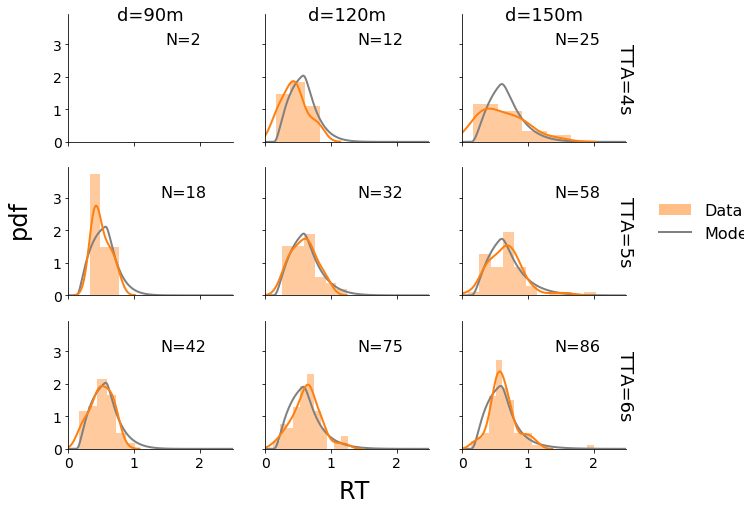

In [50]:
model_rts = pd.read_csv(os.path.join(fit_results_path, 'rt_pdf.csv'))
plot_rt_pdfs(exp_data, model_rts)
plt.savefig('figures/RT_dist.png', bbox_inches='tight')